In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans


from sklearn.decomposition import PCA
from umap_batch import UMAP
from utils import re_nn_distance, re_distance_nn

import pandas as pd  
import scipy.sparse as sp
import model
import model_refine
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [549]:
# read in dataset
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name



# # Even transform in advance, the performance is still not good.
# # read in dataset
# dir = '../data/real/diag/Xichen/'

# counts_rnas = []
# counts_atacs = []
# counts_proteins = []
# for batch in [1, 2]:
#     try:
#         counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
#         counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

#     except:
#         counts_atac = None
        
#     try:
#         counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
#         counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
#     except:
#         counts_rna = None
    
#     # preprocess the count matrix
#     counts_rnas.append(counts_rna)
#     counts_atacs.append(counts_atac)


# counts_rnas[1] = counts_atacs[1] @ A.T
# counts = {"rna":counts_rnas}

# interacts = None

# # obtain the feature name
# genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
# regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

# counts["feats_name"] = {"rna": genes}
# counts["feats_name"] = feats_name



In [24]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
K = 8
Ns = [K] * 2
N_feat = Ns[0]
interval = 100
T = 4000
lr = 1e-2

In [25]:
# didn't use the interaction matrix
model1 = model.cfrm_new(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, 
                        batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: -173.2527
	 loss 1: 89.31425
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: -62.56709
	 loss 5: 0.00000
Epoch 200, Validating Loss: -174.1075
	 loss 1: 89.30061
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: -63.40827
	 loss 5: 0.00000
Epoch 300, Validating Loss: -175.8093
	 loss 1: 89.16904
	 loss 2: 0.00000
	 loss 3: -199.99971
	 loss 4: -64.97859
	 loss 5: 0.00000
Epoch 400, Validating Loss: -179.5438
	 loss 1: 87.77003
	 loss 2: 0.00000
	 loss 3: -199.99802
	 loss 4: -67.31585
	 loss 5: 0.00000
Epoch 500, Validating Loss: -183.6394
	 loss 1: 85.86860
	 loss 2: 0.00000
	 loss 3: -199.99844
	 loss 4: -69.50960
	 loss 5: 0.00000
Epoch 600, Validating Loss: -186.3772
	 loss 1: 85.22324
	 loss 2: 0.00000
	 loss 3: -199.99925
	 loss 4: -71.60123
	 loss 5: 0.00000
Epoch 700, Validating Loss: -188.5407
	 loss 1: 84.82301
	 loss 2: 0.00000
	 loss 3: -199.99944
	 loss 4: -73.36427
	 loss 5: 0.00000
Epoch 800, Validating Loss: -1

In [26]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


## Visualize cell embedding
Extract cell factor and perform UMAP visualization

In [27]:
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())
    
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

### Ground truth labeling

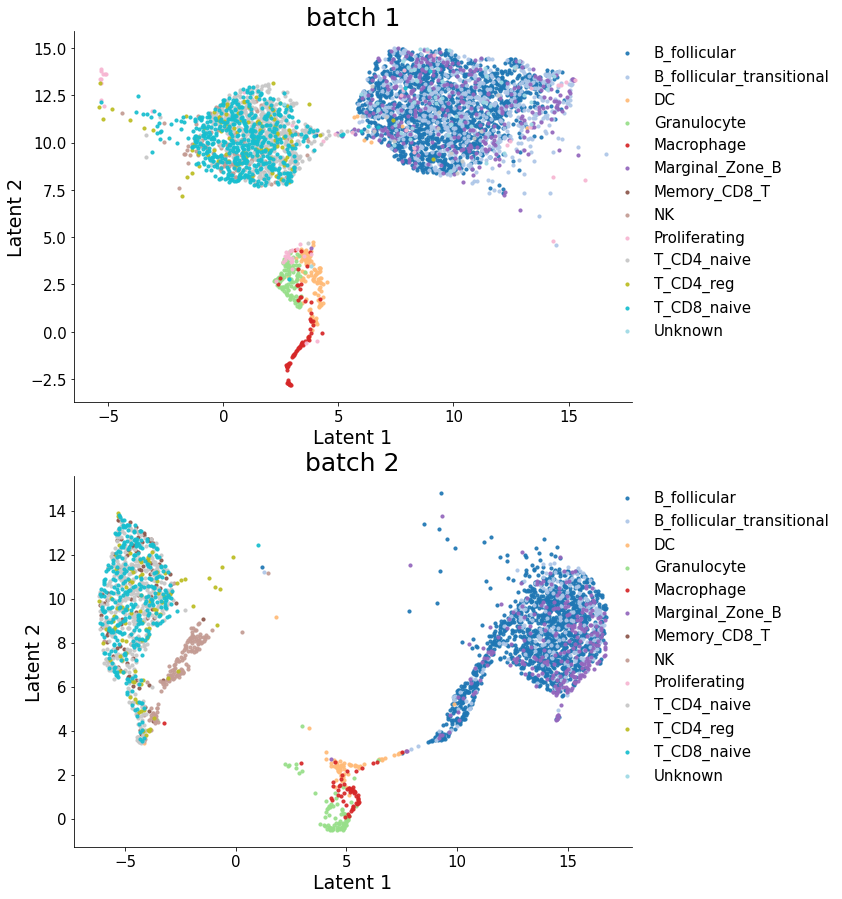

In [28]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")


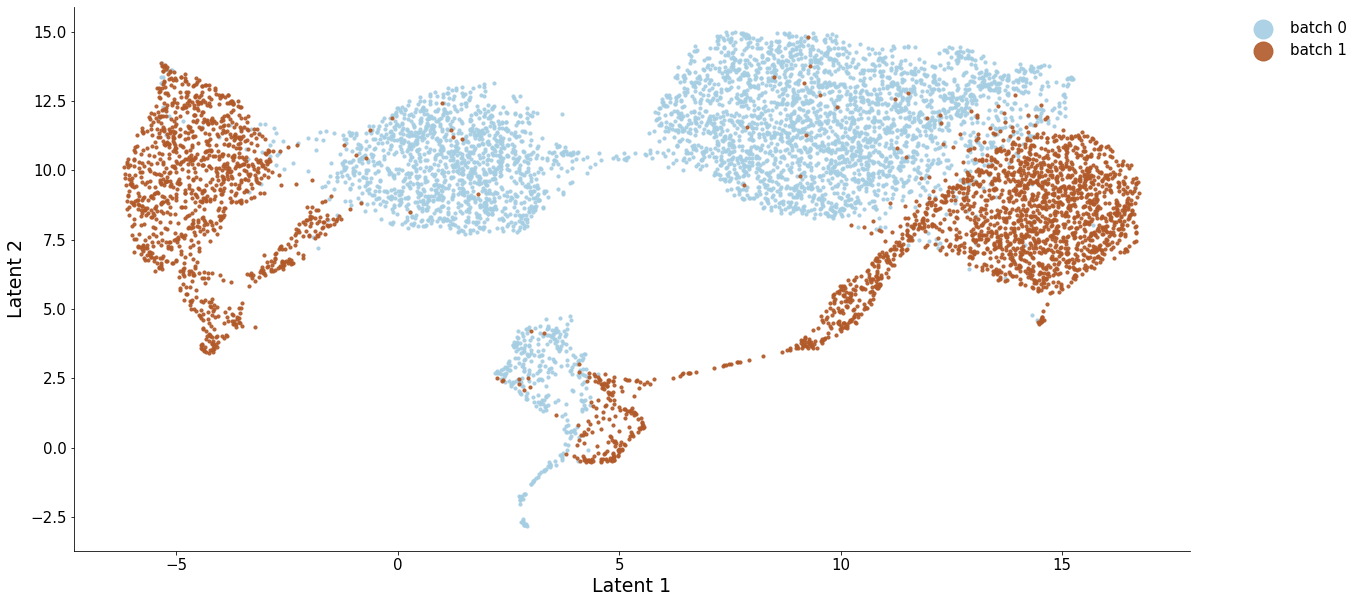

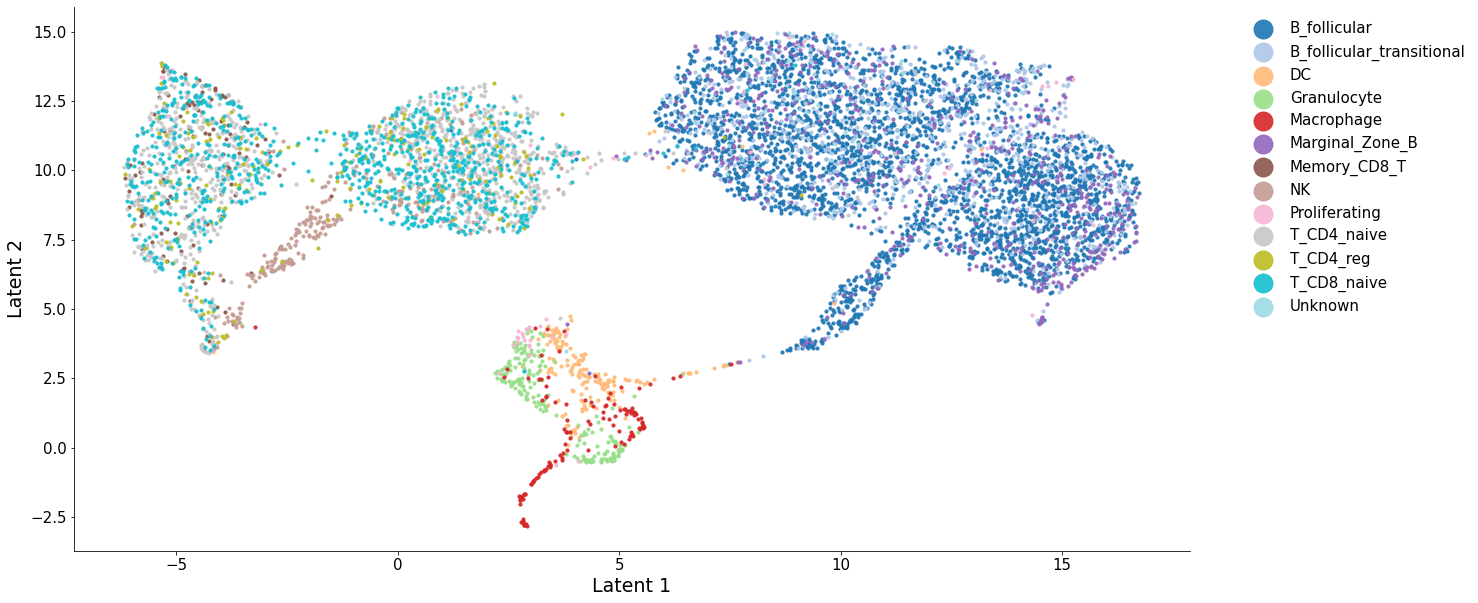

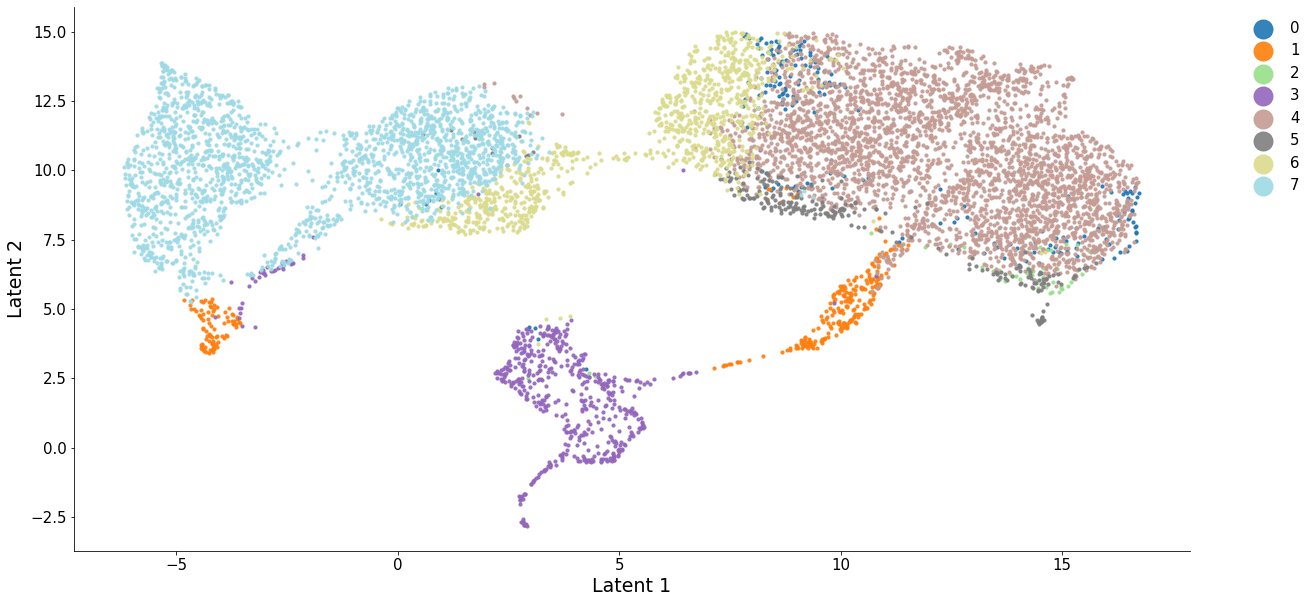

In [29]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


# CFRM_vanilla

In [2]:
# read in dataset, the result is not good, probably because we need to fix the C_gene and A_gene
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
# make scATAC and scRNA to the same scale
A = utils.preprocess(A, modality = "interaction")

counts_rnas[1] = counts_atacs[1] @ A.T
counts = {"rna":counts_rnas}

interacts = None

# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

counts["feats_name"] = {"rna": genes}



In [11]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100]
batchsize = 0.1
run = 0
K = 30
Ns = [K] * 2
N_feat = Ns[0]
interval = 500
T = 10000
lr = 1e-2

# use interaction matrix
start_time = time.time()
model1 = model_refine.cfrm_vanilla(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

Input sanity check...
Finished.
Epoch 500, Validating Loss: 51.8108
	 loss 1: 51.81078
	 loss 2: 0.00001
	 loss 3: 0.00000
Epoch 1000, Validating Loss: 50.8035
	 loss 1: 50.80353
	 loss 2: 0.00000
	 loss 3: 0.00000
Epoch 1500, Validating Loss: 50.5007
	 loss 1: 50.50063
	 loss 2: 0.00006
	 loss 3: 0.00000
Epoch 2000, Validating Loss: 50.3151
	 loss 1: 50.31511
	 loss 2: 0.00001
	 loss 3: 0.00000
Epoch 2500, Validating Loss: 50.1831
	 loss 1: 50.18306
	 loss 2: 0.00006
	 loss 3: 0.00000
Epoch 3000, Validating Loss: 50.0799
	 loss 1: 50.07986
	 loss 2: 0.00008
	 loss 3: 0.00000
Epoch 3500, Validating Loss: 49.9944
	 loss 1: 49.99433
	 loss 2: 0.00010
	 loss 3: 0.00000
Epoch 4000, Validating Loss: 49.9117
	 loss 1: 49.91162
	 loss 2: 0.00009
	 loss 3: 0.00000
Epoch 4500, Validating Loss: 49.8595
	 loss 1: 49.85939
	 loss 2: 0.00006
	 loss 3: 0.00000
Epoch 5000, Validating Loss: 49.7957
	 loss 1: 49.79559
	 loss 2: 0.00006
	 loss 3: 0.00000
Epoch 5500, Validating Loss: 49.7501
	 loss 1: 49

In [15]:
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

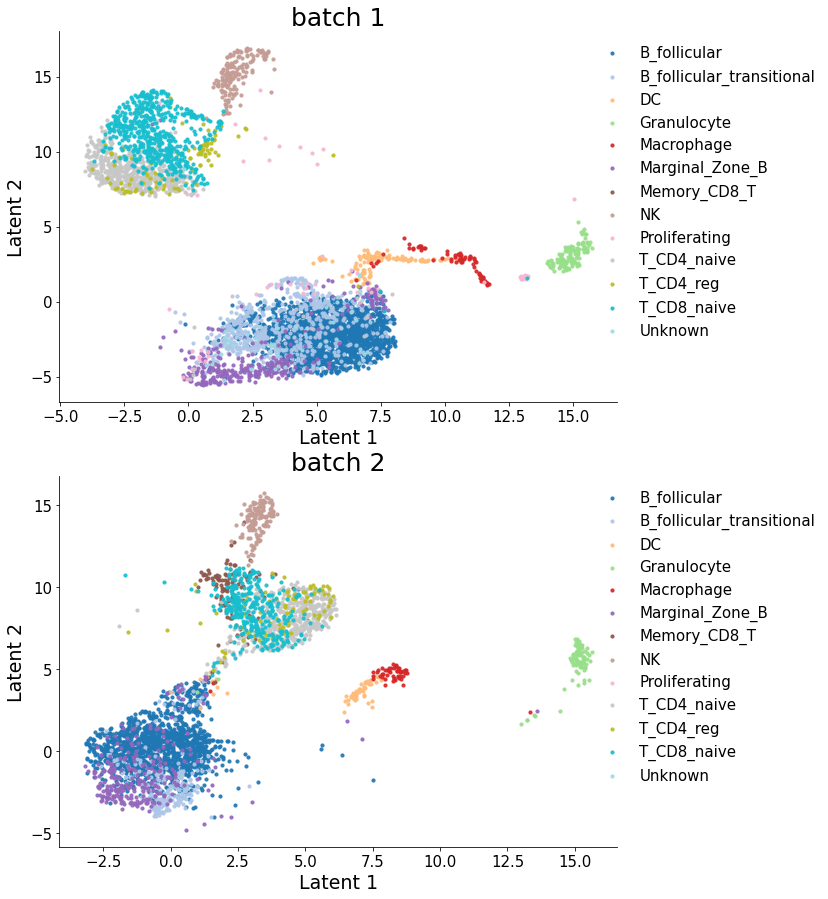

In [16]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.6, random_state = 0) 
x_umap = umap_op.fit_transform(np.concatenate(zs, axis=0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")



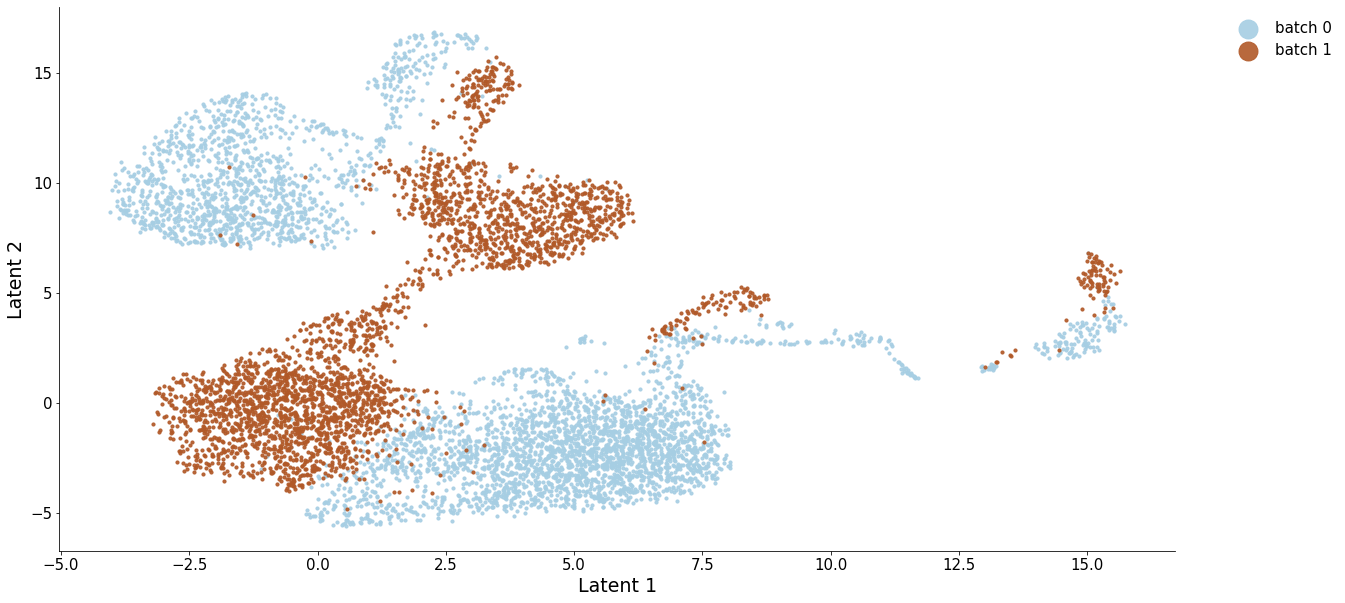

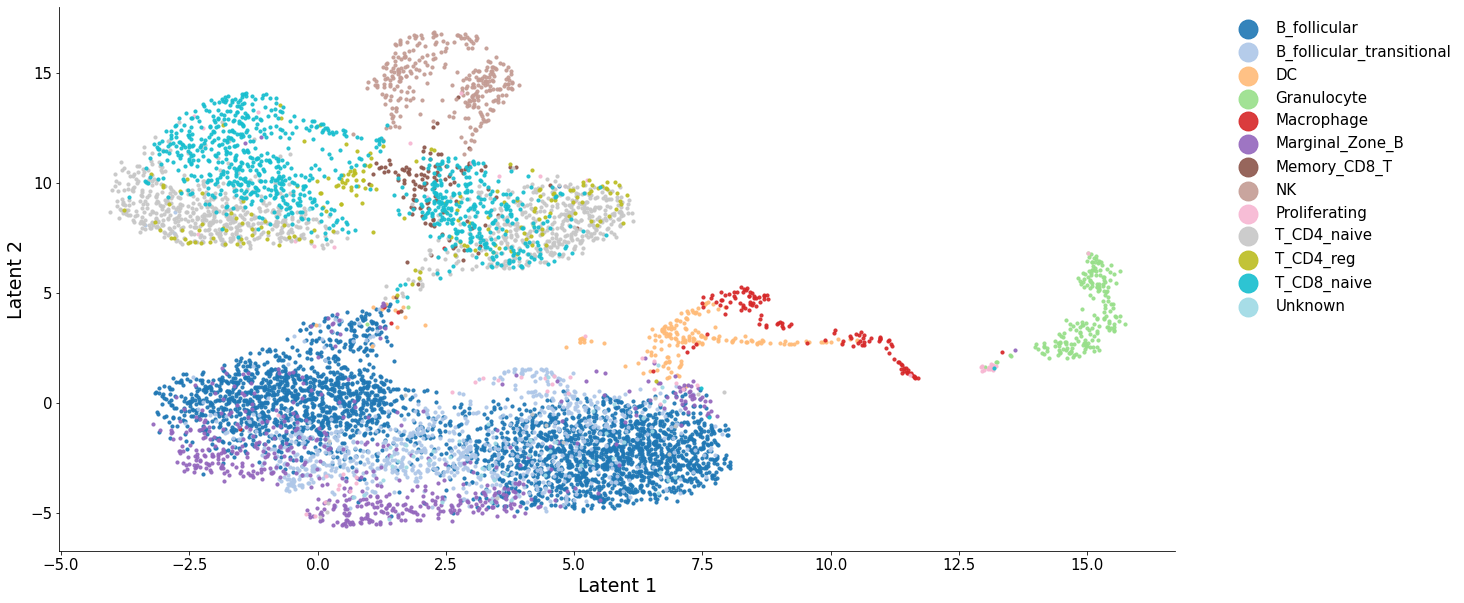

In [17]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

# Post-processing

## Method A 

Modify pairwise distance and then assign knn_indices and knn_distance

In [91]:
n_neighbors = 12
[s_pair_dist, knn_indices, knn_dists] = re_distance_nn(zs, n_neighbors)

In [94]:
umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.4, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")



/Users/xinyuchen/OneDrive - Georgia Institute of Technology/Gatech/ZhangLab/Projects/CFRM/sc_CFRM/Examples/../src/umap_batch.py:1746: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


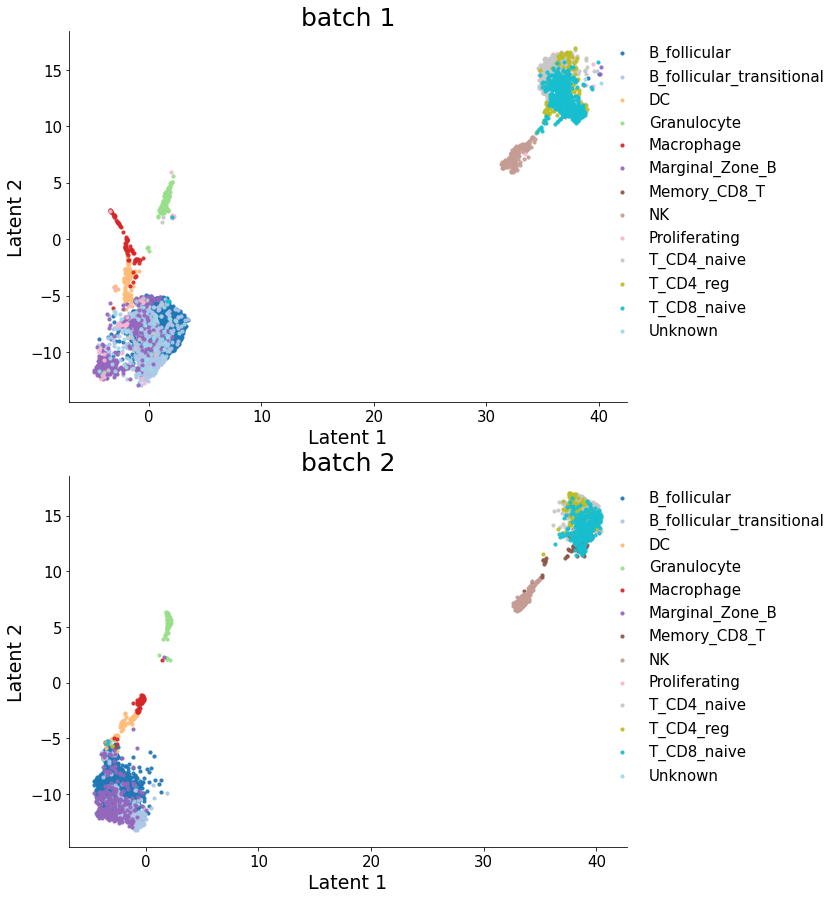

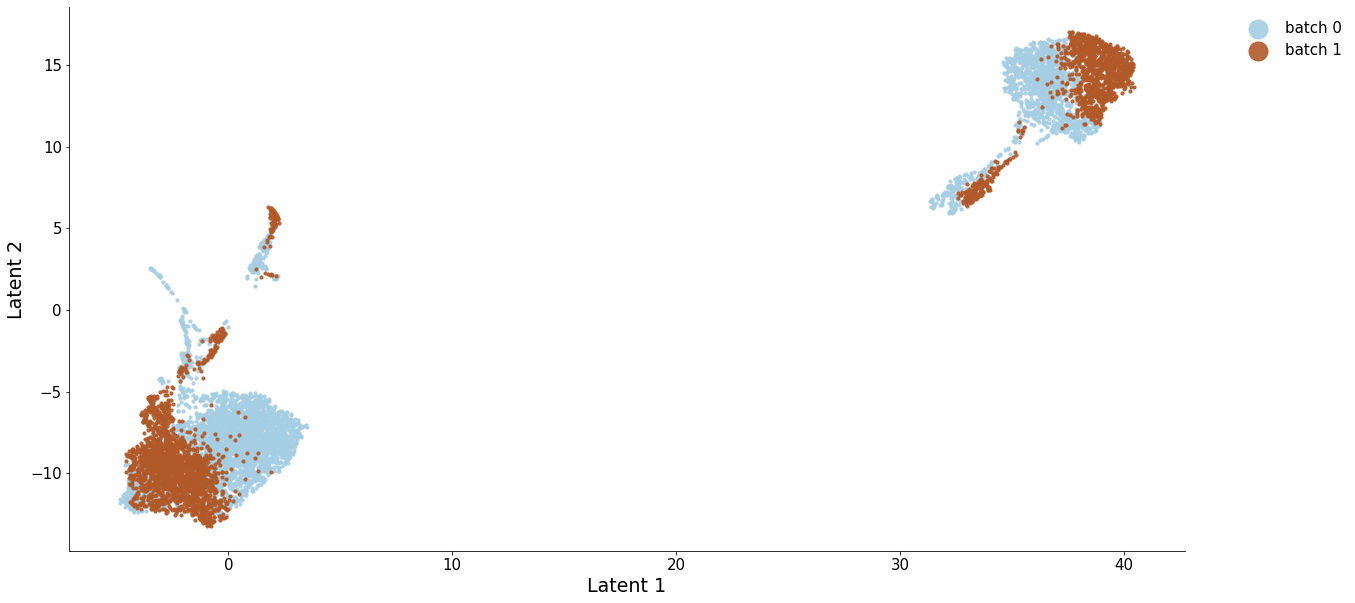

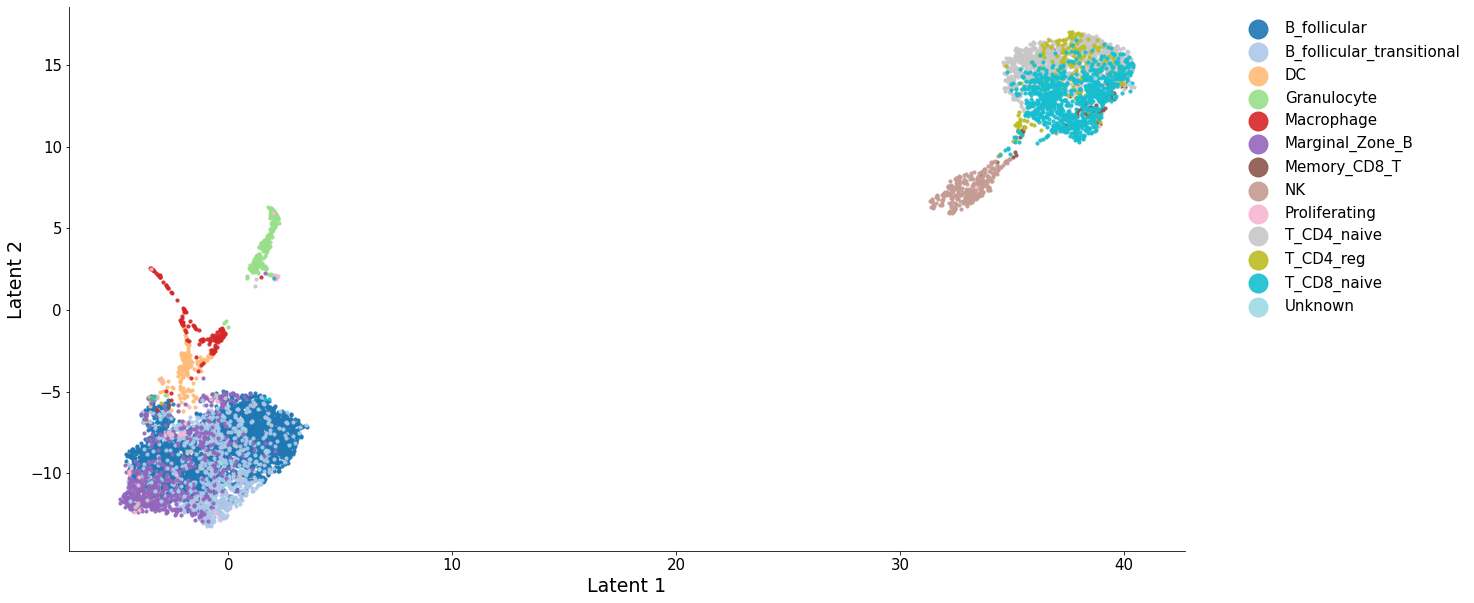

In [95]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)



## Method B

compute knn_indices first and then modify distance matrix

In [98]:
n_neighbors = 10
[s_pair_dist, knn_indices, knn_dists] = re_nn_distance(zs, n_neighbors)

In [101]:
umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.1, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])


/Users/xinyuchen/OneDrive - Georgia Institute of Technology/Gatech/ZhangLab/Projects/CFRM/sc_CFRM/Examples/../src/umap_batch.py:1746: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


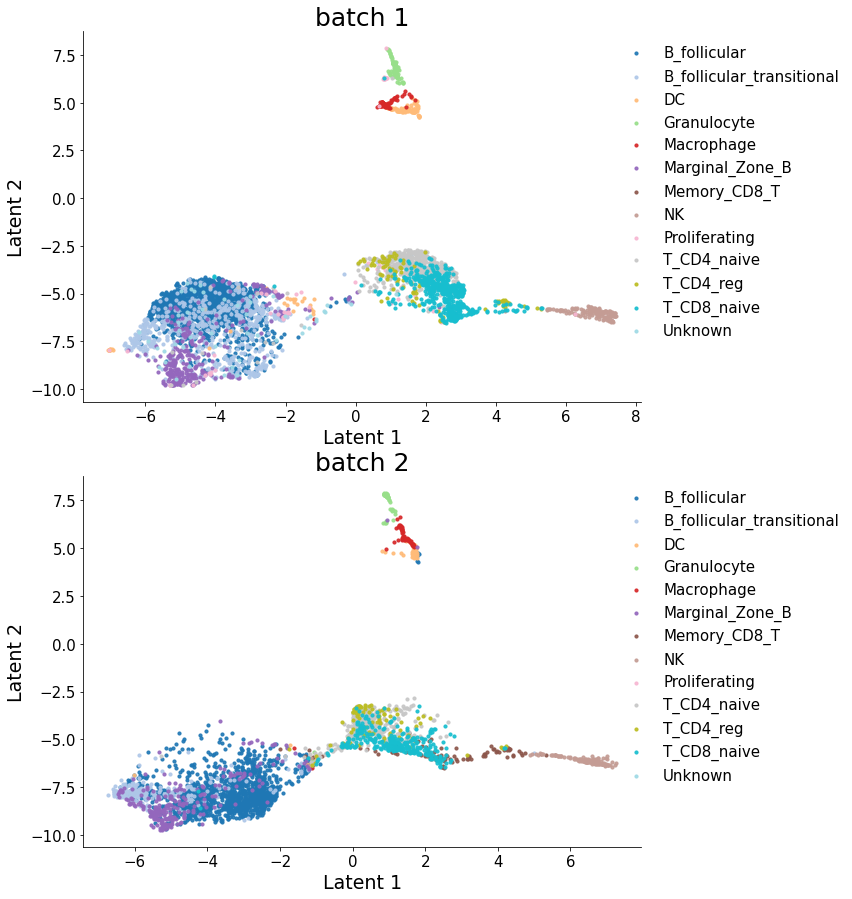

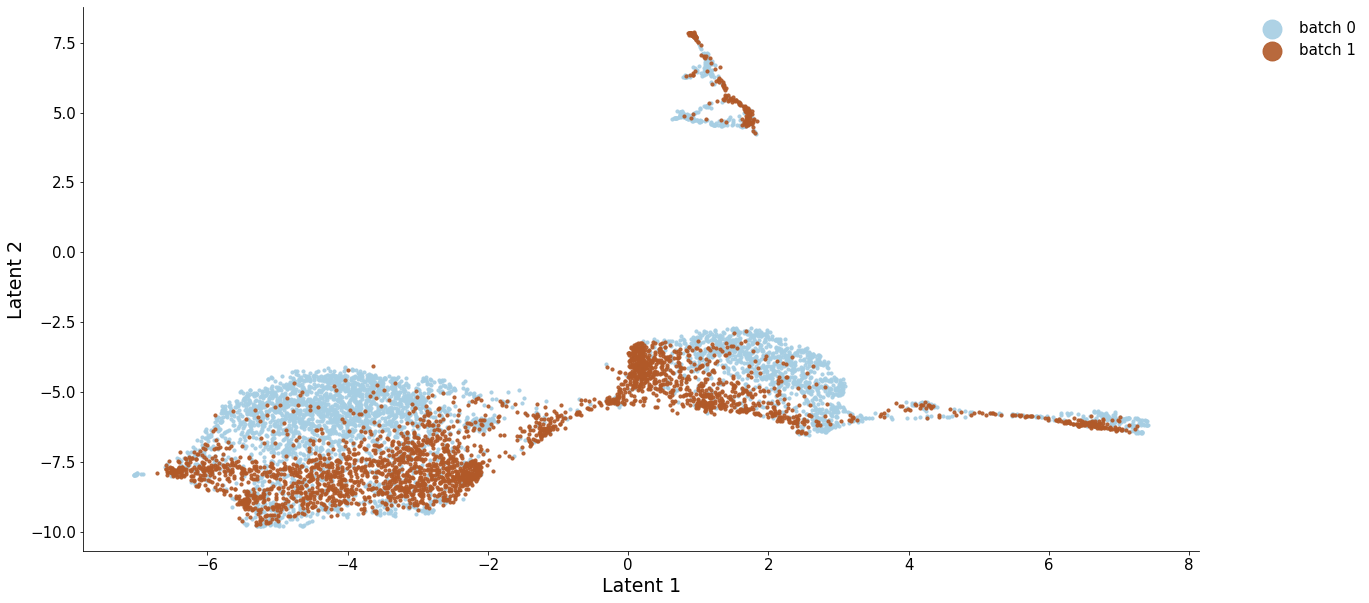

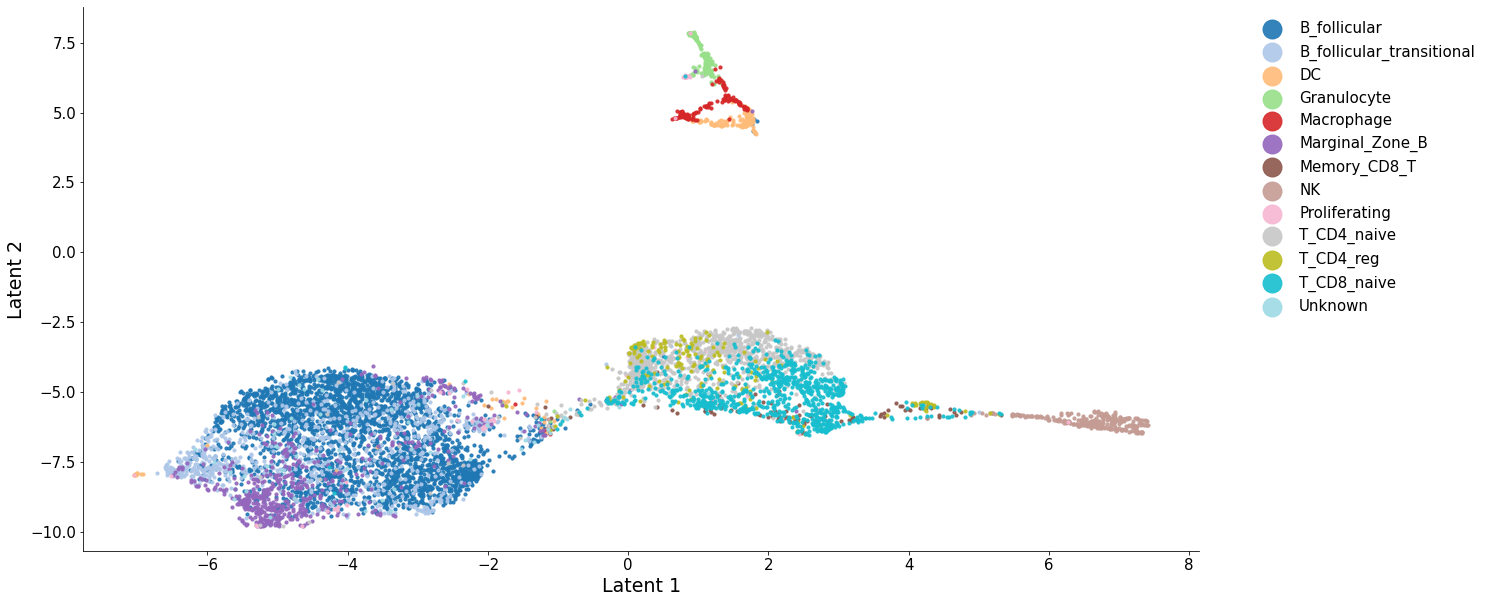

In [102]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)